In [1]:
import math                           
import numpy as np                    
from sklearn import linear_model      
from os import mkdir                  
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import scipy.stats as stats
import seaborn as sn
import statsmodels.api as sm 

Imports CSV

In [2]:
na_values= ['', 'no developer', 'no publisher']
filename = 'GAMES.csv'
df = pd.read_csv(filename, sep=',', nrows=20000000, na_values=na_values)

Drops all NaN, values go from 40K to 36K

In [3]:
df = df.dropna(how='any')

In [4]:
df.head()

,app_id,name,n_pos,n_neg,sdb_rating,price,developer,publisher,tags
0,10,Counter-Strike,167732,4340,96.22,9.99,Valve,Valve,"Strategy, Action, Survival, FPS, Classic, Tact..."
1,20,Team Fortress Classic,4576,791,82.60,4.99,Valve,Valve,"Action, FPS, Co-op, Classic, Fast-Paced, Shoot..."
2,30,Day of Defeat,4487,491,87.04,4.99,Valve,Valve,"Strategy, Action, FPS, War, Co-op, Classic, Ta..."
3,40,Deathmatch Classic,1641,350,79.13,4.99,Valve,Valve,"Action, FPS, Co-op, Classic, Fast-Paced, Shoot..."
4,50,Half-Life: Opposing Force,9737,507,92.26,4.99,Gearbox Software,Valve,"Action, Adventure, FPS, Puzzle, Moddable, Alie..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36571 entries, 0 to 40861
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   app_id      36571 non-null  int64  
 1   name        36571 non-null  object 
 2   n_pos       36571 non-null  int64  
 3   n_neg       36571 non-null  int64  
 4   sdb_rating  36571 non-null  float64
 5   price       36571 non-null  float64
 6   developer   36571 non-null  object 
 7   publisher   36571 non-null  object 
 8   tags        36571 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 2.8+ MB


In order to make histogram smooth, empirically determined 20 total reviews to be the magic number. Number of games goes to 23K

In [6]:
total = df.loc[:,"n_pos"] + df.loc[:,'n_neg']
i = total > 20

In [7]:
df[i].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23487 entries, 0 to 40846
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   app_id      23487 non-null  int64  
 1   name        23487 non-null  object 
 2   n_pos       23487 non-null  int64  
 3   n_neg       23487 non-null  int64  
 4   sdb_rating  23487 non-null  float64
 5   price       23487 non-null  float64
 6   developer   23487 non-null  object 
 7   publisher   23487 non-null  object 
 8   tags        23487 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 1.8+ MB


Histogram comparison

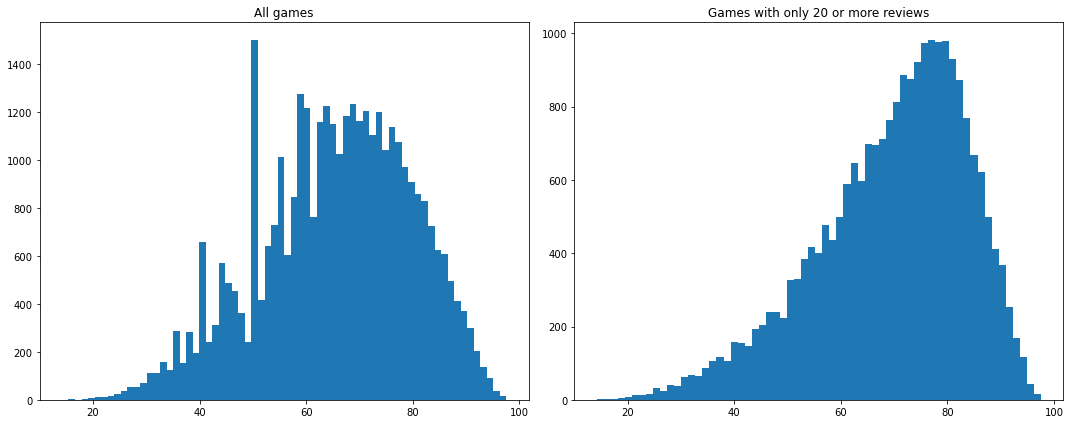

In [8]:
plt.subplots(1, 2, figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.hist(df.loc[:, 'sdb_rating'], 'auto')
plt.title('All games')

plt.subplot(1, 2, 2)
plt.hist(df.loc[:, 'sdb_rating'][i], 'auto')
plt.title('Games with only 20 or more reviews')

plt.tight_layout()
plt.show()

In [9]:
df=df[i]

Receives a dataframe with a tag column and creates a binary variable for each column

In [10]:
def createTags(dataframe):
    tags=[]
    #df = dataframe.head()
    for index, row in dataframe.iterrows():
        aux = row['tags'].split(", ")
        for i in aux:
            if i not in tags:
                tags.append(i)
                dataframe.loc[:, i] = np.zeros(np.shape(dataframe)[0])
            dataframe.at[index, i]=1
    return dataframe.drop(axis=1, labels='tags')

In [11]:
tagdf = createTags(df)

In [12]:
tagdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23487 entries, 0 to 40846
Columns: 432 entries, app_id to 8-bit Music
dtypes: float64(426), int64(3), object(3)
memory usage: 78.2+ MB


In [13]:
tagdf.head()

,app_id,name,n_pos,n_neg,sdb_rating,price,developer,publisher,Strategy,Action,...,Auto Battler,Software Training,Hardware,Electronic,Faith,Breathtaking,360 Video,Instrumental Music,Rock Music,8-bit Music
0,10,Counter-Strike,167732,4340,96.22,9.99,Valve,Valve,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20,Team Fortress Classic,4576,791,82.60,4.99,Valve,Valve,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,30,Day of Defeat,4487,491,87.04,4.99,Valve,Valve,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,40,Deathmatch Classic,1641,350,79.13,4.99,Valve,Valve,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,50,Half-Life: Opposing Force,9737,507,92.26,4.99,Gearbox Software,Valve,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
corrMatrix = tagdf.corr()

Creates an ordered list containing tuples (tag, amount of games)

In [15]:
tagdict = {}
for tag in tagdf.columns[8:]:
    tagdict[tag]=tagdf.loc[:,tag].value_counts()[1]
tagdict=sorted(tagdict.items(), key = lambda x: x[1], reverse=True)

Removes all tags below the given position in the dataframe

In [16]:
def removeTags(tagdict, number, tagdf):
    removed = [i[0] for i in tagdict[number:]]
    return tagdf.drop(axis=1, labels=removed)

In [17]:
tagdict

[('Indie', 16637),
 ('Action', 10954),
 ('Adventure', 10623),
 ('Singleplayer', 9625),
 ('Casual', 9217),
 ('Strategy', 5695),
 ('Simulation', 5628),
 ('RPG', 5071),
 ('2D', 4425),
 ('Multiplayer', 3994),
 ('Atmospheric', 3980),
 ('Great Soundtrack', 3712),
 ('Puzzle', 3694),
 ('Story Rich', 3355),
 ('Free to Play', 2983),
 ('Anime', 2936),
 ('Early Access', 2864),
 ('Difficult', 2511),
 ('Funny', 2450),
 ('First-Person', 2429),
 ('Pixel Graphics', 2425),
 ('Horror', 2398),
 ('Female Protagonist', 2266),
 ('Fantasy', 2249),
 ('Shooter', 2173),
 ('Sci-fi', 2153),
 ('Open World', 2030),
 ('Nudity', 1965),
 ('Co-op', 1957),
 ('Platformer', 1953),
 ('Cute', 1951),
 ('Retro', 1891),
 ('Violent', 1834),
 ('Arcade', 1814),
 ('Sexual Content', 1797),
 ('Visual Novel', 1744),
 ('Survival', 1727),
 ('Exploration', 1726),
 ('Gore', 1693),
 ('VR', 1689),
 ('FPS', 1662),
 ('Family Friendly', 1619),
 ('Comedy', 1543),
 ('Point & Click', 1420),
 ('Colorful', 1411),
 ('Sandbox', 1401),
 ('Relaxing', 1

In [18]:
finaldf = removeTags(tagdict, 31, tagdf)
finaldf

,app_id,name,n_pos,n_neg,sdb_rating,price,developer,publisher,Strategy,Action,...,Female Protagonist,RPG,Fantasy,Indie,2D,Pixel Graphics,Casual,Cute,Nudity,Early Access
0,10,Counter-Strike,167732,4340,96.22,9.99,Valve,Valve,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20,Team Fortress Classic,4576,791,82.60,4.99,Valve,Valve,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,30,Day of Defeat,4487,491,87.04,4.99,Valve,Valve,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,40,Deathmatch Classic,1641,350,79.13,4.99,Valve,Valve,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,50,Half-Life: Opposing Force,9737,507,92.26,4.99,Gearbox Software,Valve,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40811,1475380,TheDawn,282,19,85.86,0.00,LIMITED,LIMITED,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
40813,1475460,3 Minute Heroes,61,1,84.49,19.99,Sinkhole Studio,Sinkhole Studio,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
40819,1476350,Brain Meltdown - Into Despair,41,1,82.27,9.99,Onfire Games,Onfire Games,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
40825,1477060,Among Ass,27,1,79.58,1.99,Slippy Floor,Slippy Floor,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


Tried to get the 30 first tags for fun and this happened. Is this good? I can't tell.

In [19]:
size = np.shape(finaldf.loc[:, 'sdb_rating'])
X = np.column_stack((np.ones(size), finaldf.loc[:, 'price'], finaldf.loc[:, 'Action'],
                     finaldf.loc[:, 'Multiplayer'], finaldf.loc[:, 'Singleplayer'], finaldf.loc[:, 'Adventure'],
                    finaldf.loc[:, 'Simulation'], finaldf.loc[:, 'RPG'], finaldf.loc[:, 'Indie'], 
                    finaldf.loc[:, '2D'], finaldf.loc[:, 'Casual'], finaldf.loc[:, 'Atmospheric'], 
                    finaldf.loc[:, 'Great Soundtrack'], finaldf.loc[:, 'Puzzle'], finaldf.loc[:, 'Story Rich'], 
                    finaldf.loc[:, 'Free to Play'], finaldf.loc[:, 'Anime'], finaldf.loc[:, 'Early Access'],
                    finaldf.loc[:, 'Difficult'], finaldf.loc[:, 'Funny'], finaldf.loc[:, 'First-Person'], 
                    finaldf.loc[:, 'Pixel Graphics'], finaldf.loc[:, 'Horror'], finaldf.loc[:, 'Female Protagonist'],
                    finaldf.loc[:, 'Fantasy'], finaldf.loc[:, 'Shooter'], finaldf.loc[:, 'Sci-fi'],
                    finaldf.loc[:, 'Open World'], finaldf.loc[:, 'Nudity'], finaldf.loc[:, 'Co-op'],
                    finaldf.loc[:, 'Platformer'], finaldf.loc[:, 'Cute']))
y=finaldf.loc[:, 'sdb_rating']
model=sm.OLS(y,X)
results = model.fit() 
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             sdb_rating   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     163.9
Date:                Sun, 17 Jan 2021   Prob (F-statistic):               0.00
Time:                        21:15:17   Log-Likelihood:                -93222.
No. Observations:               23487   AIC:                         1.865e+05
Df Residuals:                   23455   BIC:                         1.868e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         63.0554      0.255    247.670      0.0

In [20]:
params = np.array(results.params)
residuals = -np.matmul(X, params) + y

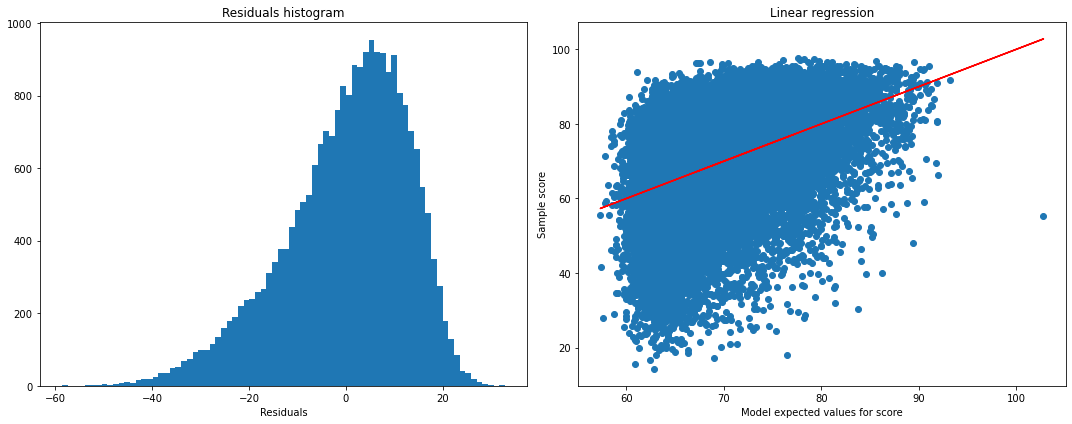

In [21]:
plt.subplots(1, 2, figsize = (15, 6))

plt.subplot(121)
plt.hist(residuals, 'auto')
plt.title('Residuals histogram')
plt.xlabel('Residuals')

plt.subplot(122)
plt.scatter(np.matmul(X, params), y)
plt.plot(np.matmul(X, params), np.matmul(X, params), color = 'red')
plt.title('Linear regression')
plt.xlabel('Model expected values for score')
plt.ylabel('Sample score')

plt.tight_layout()
plt.show()

In [28]:
coef_names=['price', 'Action',
                     'Multiplayer', 'Singleplayer', 'Adventure',
                    'Simulation', 'RPG', 'Indie', 
                    '2D', 'Casual', 'Atmospheric', 
                    'Great Soundtrack', 'Puzzle', 'Story Rich', 
                    'Free to Play', 'Anime', 'Early Access',
                    'Difficult', 'Funny', 'First-Person', 
                    'Pixel Graphics', 'Horror', 'Female Protagonist',
                    'Fantasy', 'Shooter', 'Sci-fi',
                    'Open World', 'Nudity', 'Co-op',
                    'Platformer', 'Cute']

In [30]:
regression_coef = pd.DataFrame()
regression_coef['name']= coef_names
regression_coef['value']=params[1:]

In [32]:
regression_coef=regression_coef.sort_values(by='value', ascending=False)

<BarContainer object of 31 artists>

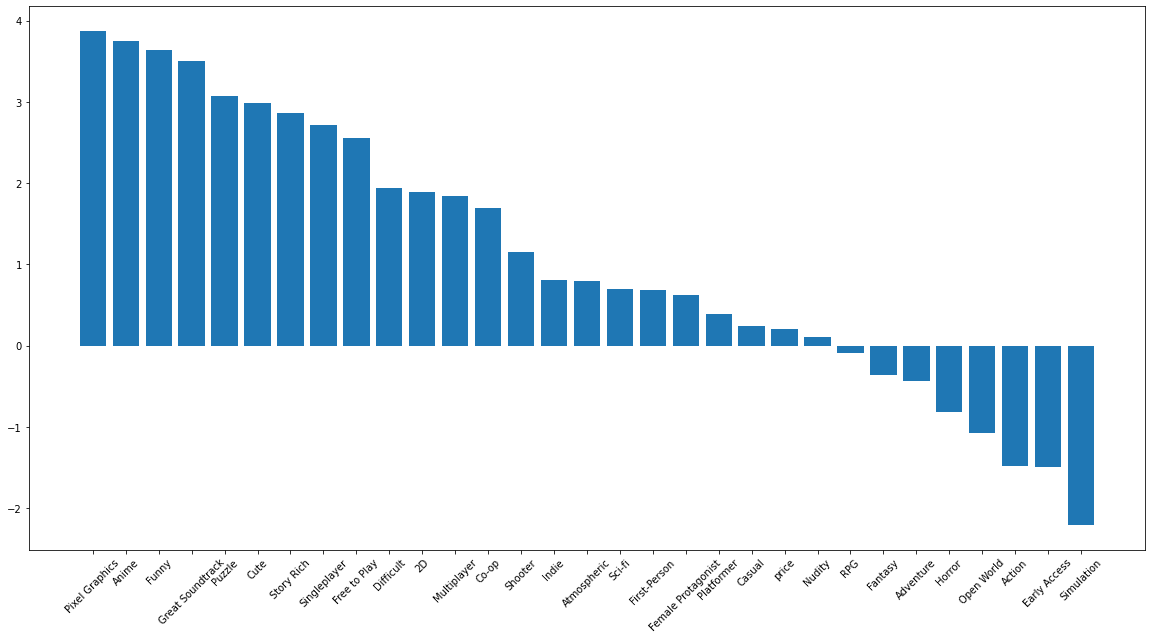

In [35]:
plt.figure(figsize=(20,10))
plt.xticks(rotation = 45)
plt.bar(regression_coef.name,regression_coef.value)